In [168]:
from pathlib import Path
import os

notebook_path = Path(os.path.abspath(""))

# A dictionary containing meta-information about conducted experiments.clear
# The code in this notebook will search for *.csv files under the specified `path` to generated plots.
# `columns_to_stack` specifies which specific measurements (CSV columns) should be included within the plots.
experiments = {
    "single-node-mpi-bounce-buf" : { 
        "title": "1 Node - 1 process per GPU - 2 GPUs per Node",
        "path" : notebook_path / ".." / "single-node" / "CHI@TACC-c11-10" / "simple_mpi_bounce_buffer",
        "nodes": ["CHI@TACC-c11-10"],
        "columns_to_stack" : ['broadcast_s', 'h2d_transfer_s', 'd2h_transfer_s', 'reduce_op_s']
    },
    "multi-node-mpi-bounce-buf" : { 
        "title": "2 Nodes - 1 process per GPU - 2 GPUs per Node",
        "path" : notebook_path / ".." / "multi-node" / "CHI@TACC-c11-10_c11-19"/ "simple_mpi_bounce_buffer",
        "nodes" : ["CHI@TACC-c11-10", "CHI@TACC-c11-19"],
        "columns_to_stack" : ['broadcast_s', 'h2d_transfer_s', 'd2h_transfer_s', 'reduce_op_s']
    },
    "single-node-mpi-nccl" : { 
        "title": "1 Node - 1 process per GPU - 2 GPUs per Node",
        "path" : notebook_path / ".." / "single-node" / "CHI@TACC-c11-10" / "simple_mpi_nccl",
        "nodes": ["CHI@TACC-c11-10"],
        "columns_to_stack" : ['wall_broadcast_s', 'wall_reduce_s',]
    },
        "multi-node-mpi-nccl" : { 
        "title": "2 Node - 1 process per GPU - 2 GPUs per Node",
        "path" : notebook_path / ".." / "multi-node" / "CHI@TACC-c11-10_c11-19" / "simple_mpi_nccl",
        "nodes" : ["CHI@TACC-c11-10", "CHI@TACC-c11-19"],
        "columns_to_stack" : ['wall_broadcast_s', 'wall_reduce_s',]
    },
}

color_coding = { 
    "broadcast" : 'tab:red', 
    "reduce" : 'tab:blue',
    "h2d_transfer" : 'tab:orange', 
    "d2h_transfer" : 'tab:olive', 
}


In [169]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np


In [170]:
# Function to convert bytes to GB for display
def bytes_to_gb(bytes_value):
    return bytes_value / (1024 ** 3)

In [173]:
def stacked_bar_chart(experiment_name: str):
    files = sorted(experiments[experiment_name]["path"].glob("data_*GB_*.csv"))

    print(f"Found {len(files)} files:")
    for file in files:
        print(f"  - {file}")

    sizes = []
    means = []
    stds = []

    columns_to_stack = experiments[experiment_name]["columns_to_stack"]
    for file in files:
        df = pd.read_csv(file)
        
        # Get the buffer size in GB (should be constant within each file)
        buffer_size_bytes = df['total_buffer_size_bytes'].iloc[0]
        buffer_size_gb = bytes_to_gb(buffer_size_bytes)
        sizes.append(f"{buffer_size_gb:.0f}GB")
        
        # Calculate mean and deviations for each column to stack
        mean_values = [df[col].mean() for col in columns_to_stack]
        std_values = [df[col].std() for col in columns_to_stack]
        
        means.append(mean_values)
        stds.append(std_values)

    means = np.array(means)
    stds = np.array(stds)


    plt.figure(figsize=(4, 4))

    bottoms = np.zeros(len(sizes))

    # Set colors for the bars
    if "bounce-buf" in experiment_name:
        colors = [color_coding["broadcast"], color_coding["h2d_transfer"], color_coding["d2h_transfer"], color_coding["reduce"]]
    elif "nccl" in experiment_name:
        colors = [color_coding["broadcast"], color_coding["reduce"]]
    else:
        raise RuntimeError("Unknown experiment type")
    
    
    # Plot each component of the stacked bar with error bars
    for i, column in enumerate(columns_to_stack):
        values = means[:, i]
        errors = stds[:, i]
        
        # The deviations from the mean runtimes are two small make out within the plots.
        # So we do not plot them
        #
        # Plot the bars with consistent colors
        # plt.bar(sizes, values, bottom=bottoms, label=column, yerr=errors, 
        #         capsize=5, color=colors[i % len(colors)])
        #
        # Instead just plot the bars without deviations
        
        plt.bar(sizes, values, bottom=bottoms, label=column, color=colors[i % len(colors)])

        # Update the bottom for the next component
        bottoms += values

    # Add labels and title
    plt.xlabel('Data Buffer Size')
    plt.ylabel('Time (seconds)')
    # plt.title(f'Runtime per buffer size\n{experiments[experiment_name]["title"]}')
    plt.legend(loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    total_time_means = [sum(measurement_steps) for measurement_steps in means ]
    # Add total time as text on top of each bar
    for i, _ in enumerate(sizes):
        total_time = total_time_means[i]
        plt.text(i, total_time + 0.01 * total_time_means[-1], f'{total_time:.2f}s', ha='center', fontweight='bold')

    plt.tight_layout()

    # Save the figure to the visualization directory
    output_dir = notebook_path / "plots" / "stacked-timings"
    output_dir.mkdir(exist_ok=True, parents=True)
    output_path = output_dir / f'{experiment_name}_stacked_timings.png'
    plt.savefig(output_path, dpi=300)
    print(f"Figure saved to {output_path}")

    plt.show()

    summary_data = {
        'Data Size': sizes
    }

    for i, col in enumerate(columns_to_stack):
        summary_data[f'{col} (mean)'] = [means[j][i] for j in range(len(sizes))]
        summary_data[f'{col} (std)'] = [stds[j][i] for j in range(len(sizes))]

    summary_df = pd.DataFrame(summary_data)
    print("\nSummary:")
    print(summary_df.to_string(index=False))


Found 4 files:
  - /home/markhun/Development/2024W-PCS/results/visualization/../single-node/CHI@TACC-c11-10/simple_mpi_bounce_buffer/data_1GB_2025-03-14T13:41:08.csv
  - /home/markhun/Development/2024W-PCS/results/visualization/../single-node/CHI@TACC-c11-10/simple_mpi_bounce_buffer/data_2GB_2025-03-14T13:37:10.csv
  - /home/markhun/Development/2024W-PCS/results/visualization/../single-node/CHI@TACC-c11-10/simple_mpi_bounce_buffer/data_4GB_2025-03-14T13:28:27.csv
  - /home/markhun/Development/2024W-PCS/results/visualization/../single-node/CHI@TACC-c11-10/simple_mpi_bounce_buffer/data_6GB_2025-03-14T13:33:34.csv
Figure saved to /home/markhun/Development/2024W-PCS/results/visualization/plots/stacked-timings/single-node-mpi-bounce-buf_stacked_timings.png


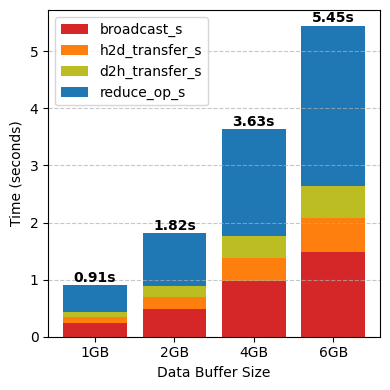


Summary:
Data Size  broadcast_s (mean)  broadcast_s (std)  h2d_transfer_s (mean)  h2d_transfer_s (std)  d2h_transfer_s (mean)  d2h_transfer_s (std)  reduce_op_s (mean)  reduce_op_s (std)
      1GB            0.246012           0.000135               0.100474              0.000023               0.093907              0.000028            0.467139           0.000156
      2GB            0.492087           0.000816               0.200880              0.000025               0.187714              0.000045            0.935455           0.000572
      4GB            0.983062           0.001074               0.401868              0.000036               0.375591              0.000050            1.869932           0.001656
      6GB            1.474726           0.001564               0.601976              0.000032               0.565311              0.000032            2.806424           0.002515


In [174]:
stacked_bar_chart("single-node-mpi-bounce-buf")

Found 4 files:
  - /home/markhun/Development/2024W-PCS/results/visualization/../multi-node/CHI@TACC-c11-10_c11-19/simple_mpi_bounce_buffer/data_1GB_2025-03-14T16:01:33.csv
  - /home/markhun/Development/2024W-PCS/results/visualization/../multi-node/CHI@TACC-c11-10_c11-19/simple_mpi_bounce_buffer/data_2GB_2025-03-14T15:57:17.csv
  - /home/markhun/Development/2024W-PCS/results/visualization/../multi-node/CHI@TACC-c11-10_c11-19/simple_mpi_bounce_buffer/data_4GB_2025-03-14T15:39:56.csv
  - /home/markhun/Development/2024W-PCS/results/visualization/../multi-node/CHI@TACC-c11-10_c11-19/simple_mpi_bounce_buffer/data_6GB_2025-03-14T15:47:44.csv
Figure saved to /home/markhun/Development/2024W-PCS/results/visualization/plots/stacked-timings/multi-node-mpi-bounce-buf_stacked_timings.png


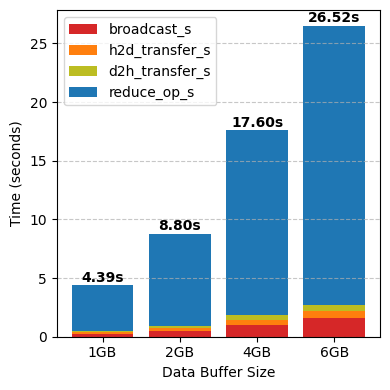


Summary:
Data Size  broadcast_s (mean)  broadcast_s (std)  h2d_transfer_s (mean)  h2d_transfer_s (std)  d2h_transfer_s (mean)  d2h_transfer_s (std)  reduce_op_s (mean)  reduce_op_s (std)
      1GB            0.261084           0.000219               0.099033              0.000024               0.093816              0.000489            3.935732           0.007570
      2GB            0.521823           0.000637               0.198027              0.000027               0.187635              0.000969            7.887591           0.047847
      4GB            1.039433           0.002244               0.395872              0.000026               0.374500              0.000027           15.787150           0.098778
      6GB            1.562662           0.003464               0.593688              0.000044               0.563534              0.000031           23.800370           0.258708


In [175]:
stacked_bar_chart("multi-node-mpi-bounce-buf")

Found 4 files:
  - /home/markhun/Development/2024W-PCS/results/visualization/../single-node/CHI@TACC-c11-10/simple_mpi_nccl/data_1GB_2025-03-14T13:57:13.csv
  - /home/markhun/Development/2024W-PCS/results/visualization/../single-node/CHI@TACC-c11-10/simple_mpi_nccl/data_2GB_2025-03-14T13:56:01.csv
  - /home/markhun/Development/2024W-PCS/results/visualization/../single-node/CHI@TACC-c11-10/simple_mpi_nccl/data_4GB_2025-03-14T13:53:08.csv
  - /home/markhun/Development/2024W-PCS/results/visualization/../single-node/CHI@TACC-c11-10/simple_mpi_nccl/data_6GB_2025-03-14T13:51:34.csv
Figure saved to /home/markhun/Development/2024W-PCS/results/visualization/plots/stacked-timings/single-node-mpi-nccl_stacked_timings.png


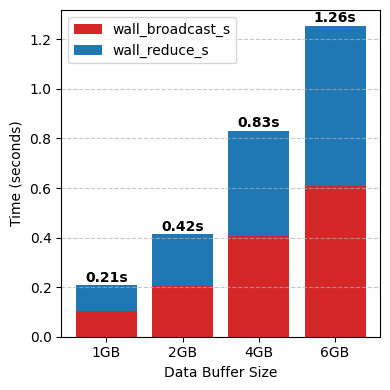


Summary:
Data Size  wall_broadcast_s (mean)  wall_broadcast_s (std)  wall_reduce_s (mean)  wall_reduce_s (std)
      1GB                 0.101776                0.000779              0.106326             0.000402
      2GB                 0.204000                0.000643              0.211617             0.000854
      4GB                 0.404444                0.000818              0.427539             0.001856
      6GB                 0.607330                0.001870              0.648217             0.004688


In [176]:
stacked_bar_chart("single-node-mpi-nccl")

In [198]:
def scaling_line_plot(experiment_name):

    files = sorted(experiments[experiment_name]["path"].glob("data_*GB_*.csv"))

    sizes = []
    means = []
    stds = []

    scaling_columns = experiments[experiment_name]["columns_to_stack"]
    for file in files:
        df = pd.read_csv(file)
        
        # Get the buffer size in GB (should be constant within each file)
        buffer_size_bytes = df['total_buffer_size_bytes'].iloc[0]
        buffer_size_gb = bytes_to_gb(buffer_size_bytes)
        sizes.append(f"{buffer_size_gb:.0f}GB")
        
        # Calculate mean and deviation
        mean_values = [df[col].mean() for col in scaling_columns]
        std_values = [df[col].std() for col in scaling_columns]
        
        means.append(mean_values)
        stds.append(std_values)

    means = np.array(means)
    stds = np.array(stds)

    plt.figure(figsize=(4, 4))

    # Set colors for the lines
    if "bounce-buf" in experiment_name:
        colors = [color_coding["broadcast"], color_coding["h2d_transfer"], color_coding["d2h_transfer"], color_coding["reduce"]]
    elif "nccl" in experiment_name:
        colors = [color_coding["broadcast"], color_coding["reduce"]]
    else:
        raise RuntimeError("Unknown experiment type")

    # Get buffer sizes in GB as numeric values for x-axis
    numeric_sizes = [float(size[:-2]) for size in sizes]

    # Plot each measurement component as a separate line
    for i, column in enumerate(scaling_columns):
        column_index = scaling_columns.index(column)
        values = means[:, column_index]
        errors = stds[:, column_index]
        
        plt.plot(numeric_sizes, values, 'o-', label=column, color=colors[i % len(colors)], linewidth=2)
        
        # The deviations from the mean runtimes are two small make out within the plots.
        # So plotting of error bands is currently commented out:
        # plt.fill_between(numeric_sizes, 
        #                 values - errors, 
        #                 values + errors, 
        #                 alpha=0., 
        #                 color=colors[i % len(colors)])

    # Add labels and title
    plt.xlabel('Data Size (GB)')
    plt.ylabel('Time (seconds)')
    # plt.title(f'Runtime Scaling for different buffer sizes\n{experiments[experiment_name]["title"]}')
    plt.legend(loc='best')
    plt.grid(True, linestyle='--', alpha=0.7)

    # log scale --- might visualize the scaling better, but is not necessary per-se
    ax = plt.gca()
    # print(numeric_sizes)
    # ax.set_yscale('log')
    # ax.set_xscale('log')
    # ax.set_xticks(numeric_sizes)
    ax.set_ylim(bottom=0)
    ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.get_xaxis().set_minor_formatter(matplotlib.ticker.ScalarFormatter())

    plt.tight_layout()

    # Save the figure to the visualization directory
    output_dir = notebook_path / "plots" / "scaling"
    output_dir.mkdir(exist_ok=True, parents=True)
    output_path = output_dir / f'{experiment_name}_scaling.png'
    plt.savefig(output_path, dpi=300)
    title = f"- {experiment_name} ---"
    print(title)
    print(f"Figure saved to {output_path}")
    plt.show()
    print("-" * len(title))
    print()

- single-node-mpi-bounce-buf ---
Figure saved to /home/markhun/Development/2024W-PCS/results/visualization/plots/scaling/single-node-mpi-bounce-buf_scaling.png


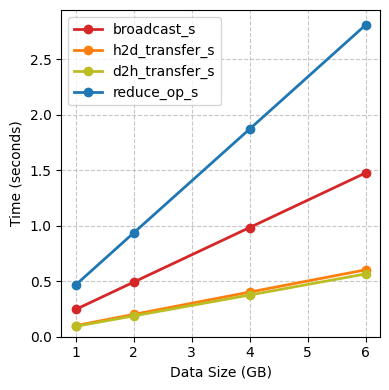

--------------------------------

- multi-node-mpi-bounce-buf ---
Figure saved to /home/markhun/Development/2024W-PCS/results/visualization/plots/scaling/multi-node-mpi-bounce-buf_scaling.png


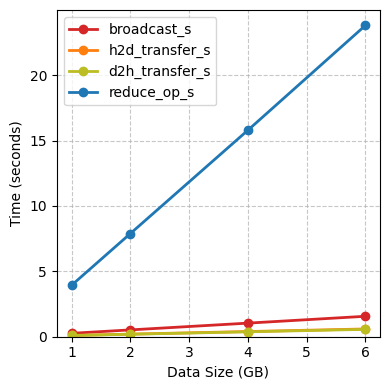

-------------------------------

- single-node-mpi-nccl ---
Figure saved to /home/markhun/Development/2024W-PCS/results/visualization/plots/scaling/single-node-mpi-nccl_scaling.png


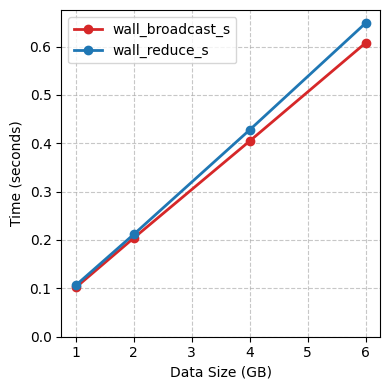

--------------------------

- multi-node-mpi-nccl ---
Figure saved to /home/markhun/Development/2024W-PCS/results/visualization/plots/scaling/multi-node-mpi-nccl_scaling.png


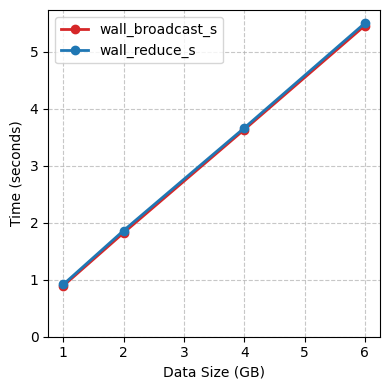

-------------------------



In [199]:
for experiment in experiments.keys():
    scaling_line_plot(experiment)

In [184]:
import matplotlib.ticker


def generate_comparison_plots(experiment_name_a, experiment_name_b):
    """
    Generate stacked bar charts comparing runtime measurements between simple_mpi_bounce_buffer
    and simple_mpi_nccl implementations for matching data sizes.
    
    Parameters:
    -----------
    experiment_name_a : str
        Directory containing e.g. mpi_bounce_buffer CSV files
    experiment_name_b : str
        Directory containing e.g. mpi_nccl CSV files
    """
    

    # Get all CSV files from both directories
    bounce_buffer_files = sorted(experiments[experiment_name_a]["path"].glob("data_*GB_*.csv"))
    print(f"Found {len(bounce_buffer_files)} files:")
    for file in bounce_buffer_files:
        print(f"  - {file}")
    nccl_files = sorted(experiments[experiment_name_b]["path"].glob("data_*GB_*.csv"))
    # Print found files
    print(f"Found {len(nccl_files)} files:")
    for file in nccl_files:
        print(f"  - {file}")
    
    # Extract data sizes from filenames
    bounce_buffer_sizes = []
    for file in bounce_buffer_files:
        df = pd.read_csv(file)
        
        # Get the buffer size in GB (assuming it's constant within each file)
        buffer_size_bytes = df['total_buffer_size_bytes'].iloc[0]
        buffer_size_gb = bytes_to_gb(buffer_size_bytes)
        bounce_buffer_sizes.append(buffer_size_gb)


    nccl_sizes = []
    for file in bounce_buffer_files:
        df = pd.read_csv(file)
        
        # Get the buffer size in GB (assuming it's constant within each file)
        buffer_size_bytes = df['total_buffer_size_bytes'].iloc[0]
        buffer_size_gb = bytes_to_gb(buffer_size_bytes)
        nccl_sizes.append(buffer_size_gb)
    
    assert bounce_buffer_sizes == nccl_sizes
    
    # Common data sizes between both implementations
    common_sizes = bounce_buffer_sizes
    
    # Create a figure with subplots arranged horizontally with shared y-axis
    # fig, axes = plt.subplots(1, len(common_sizes), figsize=(5 * len(common_sizes), 8), sharey=True)
    fig, axes = plt.subplots(1, len(common_sizes), figsize=(2 * len(common_sizes), 4.5), sharey=True)

    # Ensure axes is an array even if there's only one subplot
    if len(common_sizes) == 1:
        axes = [axes]
    
    # Define color scheme
    bounce_buffer_colors = [color_coding["broadcast"], color_coding["reduce"], color_coding["h2d_transfer"], color_coding["d2h_transfer"]]

    nccl_colors =  [color_coding["broadcast"], color_coding["reduce"]]

    # Set up bar width and positions
    bar_width = 0.9
    index = np.array([0, 1])
    
    # Initialize lists for legend handles and labels
    legend_handles = []
    legend_labels = []
    
    # Process each common data size
    for i, size in enumerate(common_sizes):
        ax = axes[i]
        
        bounce_buffer_file = bounce_buffer_files[i]
        nccl_file = nccl_files[i]
        
        # Read the CSV files
        bounce_buffer_df = pd.read_csv(bounce_buffer_file)
        nccl_df = pd.read_csv(nccl_file)
        
        # Calculate means for bounce_buffer measurements
        bb_broadcast_mean = bounce_buffer_df['broadcast_s'].mean()
        bb_reduce_op_mean = bounce_buffer_df['reduce_op_s'].mean()
        bb_h2d_transfer_mean = bounce_buffer_df['h2d_transfer_s'].mean()
        bb_d2h_transfer_mean = bounce_buffer_df['d2h_transfer_s'].mean()

        
        # Calculate means for nccl measurements
        nccl_broadcast_mean = nccl_df['wall_broadcast_s'].mean()
        nccl_reduce_mean = nccl_df['wall_reduce_s'].mean()
        
        # Create stacked bar for bounce_buffer
        bounce_buffer_data = [
            bb_broadcast_mean,
            bb_reduce_op_mean,
            bb_h2d_transfer_mean,
            bb_d2h_transfer_mean,
        ]
        
        bounce_buffer_labels = [
            'broadcast',
            'reduce',
            'h2d transfer',
            'd2h transfer',
        ]
        
        bottom = 0
        for j, (value, label, color) in enumerate(zip(bounce_buffer_data, bounce_buffer_labels, bounce_buffer_colors)):
            bar = ax.bar(index[0], value, bar_width, bottom=bottom, color=color)
            bottom += value
            
            # Add to legend only for the first subplot
            if i == 0:
                legend_handles.append(plt.Rectangle((0, 0), 1, 1, color=color))
                legend_labels.append(label)
        
        # Create stacked bar for nccl
        nccl_data = [
            nccl_broadcast_mean,
            nccl_reduce_mean
        ]
        
        nccl_labels = [
            'broadcast',
            'reduce'
        ]
        
        bottom = 0
        for j, (value, label, color) in enumerate(zip(nccl_data, nccl_labels, nccl_colors)):
            ax.bar(index[1], value, bar_width, bottom=bottom, color=color) 
            bottom += value
            
        
        # Set x-ticks for each subplot
        ax.set_xticks(index)
        ax.set_xticklabels(['MPI with\nbounce buffer', 'NCCL'], rotation=0, ha='center')
        
        # Add title for each subplot
        ax.set_title(f'Buffer Size: {int(size)}GB')
        
        # Add total time annotation on top of each bar
        total_bb_time = sum(bounce_buffer_data)
        total_nccl_time = sum(nccl_data)
        ax.text(index[0], total_bb_time + 0.05, f'{total_bb_time:.2f}s', 
                ha='center', va='bottom', fontweight='bold')
        ax.text(index[1], total_nccl_time + 0.05, f'{total_nccl_time:.2f}s', 
                ha='center', va='bottom', fontweight='bold')
        
        # Only add y-label to the first subplot (leftmost)
        if i == 0:
            ax.set_ylabel('Time (seconds)')
    
    # Format y-axis with seconds for the first subplot (it will be shared with all)
    def seconds_formatter(x, pos):
        return f'{x:.2f} s'
    
    axes[0].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(seconds_formatter))
    
    # Add an overall title
    # fig.suptitle('Runtime Comparison: simple_mpi_bounce_buffer vs simple_mpi_nccl', fontsize=16)
    
    # Add a single legend for the entire figure
    fig.legend(legend_handles, legend_labels, loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=len(legend_handles))
    
    # Adjust layout and save
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Make room for the legend and title
    
    # Create output directory if needed
    # output_dir = os.path.dirname(output_file)
    # if output_dir and not os.path.exists(output_dir):
    #     os.makedirs(output_dir)
    
    # plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()

Found 4 files:
  - /home/markhun/Development/2024W-PCS/results/visualization/../single-node/CHI@TACC-c11-10/simple_mpi_bounce_buffer/data_1GB_2025-03-14T13:41:08.csv
  - /home/markhun/Development/2024W-PCS/results/visualization/../single-node/CHI@TACC-c11-10/simple_mpi_bounce_buffer/data_2GB_2025-03-14T13:37:10.csv
  - /home/markhun/Development/2024W-PCS/results/visualization/../single-node/CHI@TACC-c11-10/simple_mpi_bounce_buffer/data_4GB_2025-03-14T13:28:27.csv
  - /home/markhun/Development/2024W-PCS/results/visualization/../single-node/CHI@TACC-c11-10/simple_mpi_bounce_buffer/data_6GB_2025-03-14T13:33:34.csv
Found 4 files:
  - /home/markhun/Development/2024W-PCS/results/visualization/../single-node/CHI@TACC-c11-10/simple_mpi_nccl/data_1GB_2025-03-14T13:57:13.csv
  - /home/markhun/Development/2024W-PCS/results/visualization/../single-node/CHI@TACC-c11-10/simple_mpi_nccl/data_2GB_2025-03-14T13:56:01.csv
  - /home/markhun/Development/2024W-PCS/results/visualization/../single-node/CHI@T

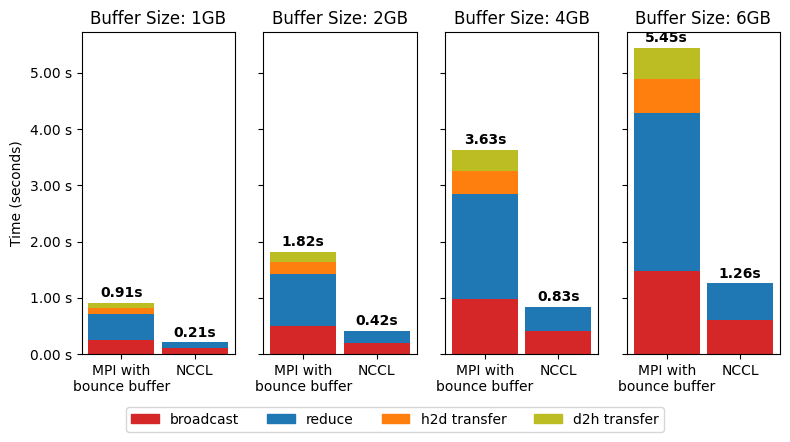

In [185]:
generate_comparison_plots("single-node-mpi-bounce-buf", "single-node-mpi-nccl")

Found 4 files:
  - /home/markhun/Development/2024W-PCS/results/visualization/../multi-node/CHI@TACC-c11-10_c11-19/simple_mpi_bounce_buffer/data_1GB_2025-03-14T16:01:33.csv
  - /home/markhun/Development/2024W-PCS/results/visualization/../multi-node/CHI@TACC-c11-10_c11-19/simple_mpi_bounce_buffer/data_2GB_2025-03-14T15:57:17.csv
  - /home/markhun/Development/2024W-PCS/results/visualization/../multi-node/CHI@TACC-c11-10_c11-19/simple_mpi_bounce_buffer/data_4GB_2025-03-14T15:39:56.csv
  - /home/markhun/Development/2024W-PCS/results/visualization/../multi-node/CHI@TACC-c11-10_c11-19/simple_mpi_bounce_buffer/data_6GB_2025-03-14T15:47:44.csv
Found 4 files:
  - /home/markhun/Development/2024W-PCS/results/visualization/../multi-node/CHI@TACC-c11-10_c11-19/simple_mpi_nccl/data_1GB_2025-03-14T16:14:52.csv
  - /home/markhun/Development/2024W-PCS/results/visualization/../multi-node/CHI@TACC-c11-10_c11-19/simple_mpi_nccl/data_2GB_2025-03-14T16:11:04.csv
  - /home/markhun/Development/2024W-PCS/result

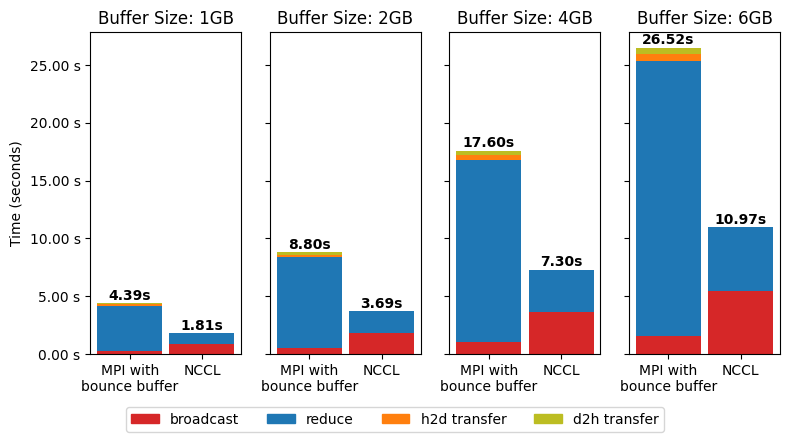

In [186]:
generate_comparison_plots("multi-node-mpi-bounce-buf", "multi-node-mpi-nccl")

In [195]:
def compare_scaling_line_plot(experiment_name_a, experiment_name_b):

    sizes = set()

    def _read_in(experiment_name):
        nonlocal sizes

        files = sorted(experiments[experiment_name]["path"].glob("data_*GB_*.csv"))

        means = []
        stds = []

        scaling_columns = experiments[experiment_name]["columns_to_stack"]
        for file in files:
            df = pd.read_csv(file)
            
            # Get the buffer size in GB (should be constant within each file)
            buffer_size_bytes = df['total_buffer_size_bytes'].iloc[0]
            buffer_size_gb = bytes_to_gb(buffer_size_bytes)
            sizes.add(f"{buffer_size_gb:.0f}GB")
            
            # Calculate mean and deviation
            mean_values = [df[col].mean() for col in scaling_columns]
            std_values = [df[col].std() for col in scaling_columns]
            
            means.append(mean_values)
            stds.append(std_values)

        means = np.array(means)
        stds = np.array(stds)

        return scaling_columns, means, stds

    scaling_columns_a, means_a, stds_a = _read_in(experiment_name_a)
    scaling_columns_b, means_b, stds_b = _read_in(experiment_name_b)

    fig, axes = plt.subplots(1, 2, figsize=(6, 4), sharey=True, sharex=True)

    # Set colors for the lines
    bounce_buffer_colors = [color_coding["broadcast"], color_coding["h2d_transfer"], color_coding["d2h_transfer"], color_coding["reduce"]]
    nccl_colors =  [color_coding["broadcast"], color_coding["reduce"]]

    print(sizes)
    # Get buffer sizes in GB as numeric values for x-axis
    numeric_sizes = [float(size[:-2]) for size in sorted(sizes)]

    def _add_lines_to_plot(scaling_columns, means, stds, colors, ax):
        # Plot each measurement component as a separate line
        for i, column in enumerate(scaling_columns):
            column_index = scaling_columns.index(column)
            values = means[:, column_index]
            errors = stds[:, column_index]
            
            print(f"{numeric_sizes=}")
            print(f"{values=}")
            ls=['-.','--',':'][i%3]
            marker=['s', 'x', 's'][i%3]
            ax.plot(numeric_sizes, values, ls, marker = marker, label=column, color=colors[i % len(colors)], linewidth=2)
            
            # The deviations from the mean runtimes are two small make out within the plots.
            # So plotting of error bands is currently commented out:
            # plt.fill_between(numeric_sizes, 
            #                 values - errors, 
            #                 values + errors, 
            #                 alpha=0., 
            #                 color=colors[i % len(colors)])
        
        ax.legend(loc='best')
        # ax.set_yscale('log')
        # ax.set_xscale('log')
        # ax.set_ylim(ymin=0, ymax=25)
        ax.set_ylim(bottom=0)
        ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
        ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        ax.get_xaxis().set_minor_formatter(matplotlib.ticker.ScalarFormatter())
        ax.grid(True, linestyle='--', alpha=0.7)

    
    _add_lines_to_plot(scaling_columns_a, means_a, stds_a, bounce_buffer_colors, axes[0])
    _add_lines_to_plot(scaling_columns_b, means_b, stds_b, nccl_colors, axes[1])


    # Add labels and title
    # plt.xlabel('Data Size (GB)')
    # plt.ylabel('Time (seconds)')
    # common axis labels
    fig.supxlabel('Data Size (GB)')
    fig.supylabel('Time (seconds)')

    plt.tight_layout()

    # Save the figure to the visualization directory
    output_dir = notebook_path / "plots" / "scaling"
    output_dir.mkdir(exist_ok=True, parents=True)
    output_path = output_dir / f'comparison_scaling.png'
    # plt.savefig(output_path, dpi=300)
    title = f"- {experiment_name_a} | {experiment_name_b} ---"
    print(title)
    print(f"Figure saved to {output_path}")
    plt.show()
    print("-" * len(title))
    print()

{'4GB', '1GB', '2GB', '6GB'}
numeric_sizes=[1.0, 2.0, 4.0, 6.0]
values=array([0.2610835, 0.5218228, 1.039433 , 1.562662 ])
numeric_sizes=[1.0, 2.0, 4.0, 6.0]
values=array([0.0990327, 0.1980266, 0.3958722, 0.5936882])
numeric_sizes=[1.0, 2.0, 4.0, 6.0]
values=array([0.09381575, 0.1876348 , 0.3745005 , 0.5635337 ])
numeric_sizes=[1.0, 2.0, 4.0, 6.0]
values=array([ 3.935732,  7.887591, 15.78715 , 23.80037 ])
numeric_sizes=[1.0, 2.0, 4.0, 6.0]
values=array([0.8936374, 1.82439  , 3.636509 , 5.46517  ])
numeric_sizes=[1.0, 2.0, 4.0, 6.0]
values=array([0.917276, 1.864388, 3.666071, 5.506744])
- multi-node-mpi-bounce-buf | multi-node-mpi-nccl ---
Figure saved to /home/markhun/Development/2024W-PCS/results/visualization/plots/scaling/comparison_scaling.png


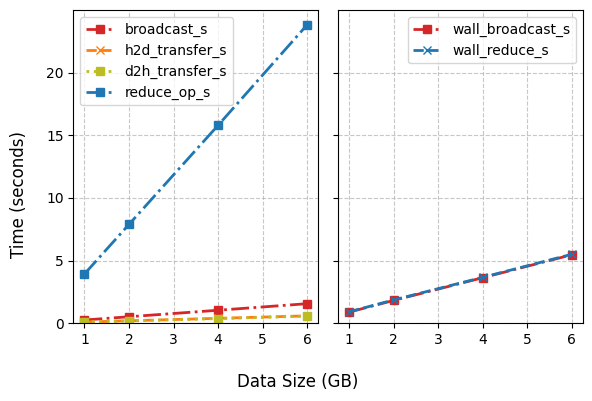

-----------------------------------------------------



In [196]:
compare_scaling_line_plot("multi-node-mpi-bounce-buf", "multi-node-mpi-nccl")

{'4GB', '1GB', '2GB', '6GB'}
numeric_sizes=[1.0, 2.0, 4.0, 6.0]
values=array([0.2460122, 0.492087 , 0.9830625, 1.474726 ])
numeric_sizes=[1.0, 2.0, 4.0, 6.0]
values=array([0.1004738, 0.2008802, 0.4018683, 0.6019762])
numeric_sizes=[1.0, 2.0, 4.0, 6.0]
values=array([0.09390675, 0.1877141 , 0.3755913 , 0.5653107 ])
numeric_sizes=[1.0, 2.0, 4.0, 6.0]
values=array([0.467139 , 0.9354547, 1.869932 , 2.806424 ])
numeric_sizes=[1.0, 2.0, 4.0, 6.0]
values=array([0.1017764, 0.2040002, 0.4044435, 0.60733  ])
numeric_sizes=[1.0, 2.0, 4.0, 6.0]
values=array([0.1063265, 0.2116172, 0.4275387, 0.6482166])
- single-node-mpi-bounce-buf | single-node-mpi-nccl ---
Figure saved to /home/markhun/Development/2024W-PCS/results/visualization/plots/scaling/comparison_scaling.png


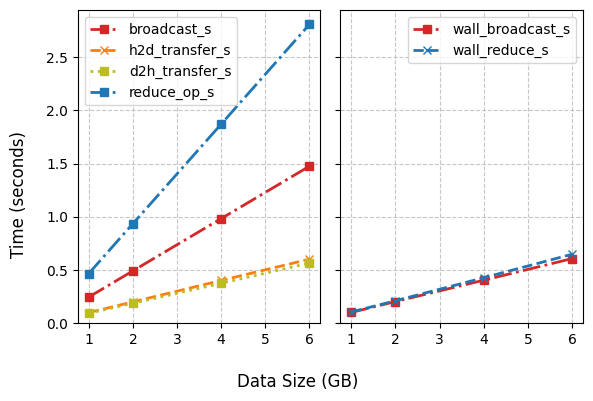

-------------------------------------------------------



In [197]:
compare_scaling_line_plot("single-node-mpi-bounce-buf", "single-node-mpi-nccl")